In [102]:
!pip install nibabel h5py

Defaulting to user installation because normal site-packages is not writeable
    scikit-image (<0.19.0>=0.16.1) ; extra == 'all'
                 ~~~~~~~~^

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [103]:
# Load & Preprocessing
import os
import shutil
import glob
import random
import numpy as np
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
from PIL import Image, ImageOps
from skimage import data, transform, util
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF


In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt


In [13]:
!ls data/BraTS2020_training_data/content/data/

meta_data.csv           volume_210_slice_98.h5  volume_321_slice_99.h5
name_mapping.csv        volume_210_slice_99.h5  volume_322_slice_0.h5
survival_info.csv       volume_211_slice_0.h5   volume_322_slice_1.h5
volume_100_slice_0.h5   volume_211_slice_1.h5   volume_322_slice_10.h5
volume_100_slice_1.h5   volume_211_slice_10.h5  volume_322_slice_100.h5
volume_100_slice_10.h5  volume_211_slice_100.h5 volume_322_slice_101.h5
volume_100_slice_100.h5 volume_211_slice_101.h5 volume_322_slice_102.h5
volume_100_slice_101.h5 volume_211_slice_102.h5 volume_322_slice_103.h5
volume_100_slice_102.h5 volume_211_slice_103.h5 volume_322_slice_104.h5
volume_100_slice_103.h5 volume_211_slice_104.h5 volume_322_slice_105.h5
volume_100_slice_104.h5 volume_211_slice_105.h5 volume_322_slice_106.h5
volume_100_slice_105.h5 volume_211_slice_106.h5 volume_322_slice_107.h5
volume_100_slice_106.h5 volume_211_slice_107.h5 volume_322_slice_108.h5
volume_100_slice_107.h5 volume_211_slice_108.h5 volume_322_slice_109.h

In [105]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch

def normalize(img):
    """Normalize a single MRI modality to [0, 1] range."""
    img = img.astype(np.float32)
    img_min, img_max = np.min(img), np.max(img)
    if img_max - img_min > 0:
        img = (img - img_min) / (img_max - img_min)
    return img

def load_and_visualize_brats_slice(h5_file, to_tensor=False):
    """
    Load and visualize one BraTS .h5 slice.
    Each file should contain 'image' with shape (H, W, 4):
        [T1, T2, FLAIR, T1CE]
    """

    # Load .h5 file
    with h5py.File(h5_file, "r") as f:
        image = f["image"][:]   # (H, W, 4)

    print(f"Loaded {os.path.basename(h5_file)} | Shape: {image.shape}")

    # Extract modalities
    t1 = normalize(image[:, :, 0])
    t2 = normalize(image[:, :, 1])
    flair = normalize(image[:, :, 2])
    t1ce = normalize(image[:, :, 3])

    # Stack first 3 as RGB-like image
    stacked_image = np.stack([t1, t2, flair], axis=-1)  # (H, W, 3)

    # Visualization
    modalities = [t1, t2, flair, t1ce]
    titles = ["T1-weighted", "T2-weighted", "FLAIR", "T1CE"]
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    for i in range(4):
        axes[i].imshow(modalities[i], cmap="gray")
        axes[i].set_title(titles[i])
        axes[i].axis("off")

    axes[4].imshow(stacked_image)
    axes[4].set_title("Stacked (T1, T2, FLAIR)")
    axes[4].axis("off")

    plt.tight_layout()
    plt.show()

    # Optionally convert to PyTorch tensor for model input
    if to_tensor:
        tensor_img = torch.tensor(stacked_image.transpose(2, 0, 1)).float()  # (3, H, W)
        return tensor_img

    return stacked_image


Loaded volume_100_slice_102.h5 | Shape: (240, 240, 4)


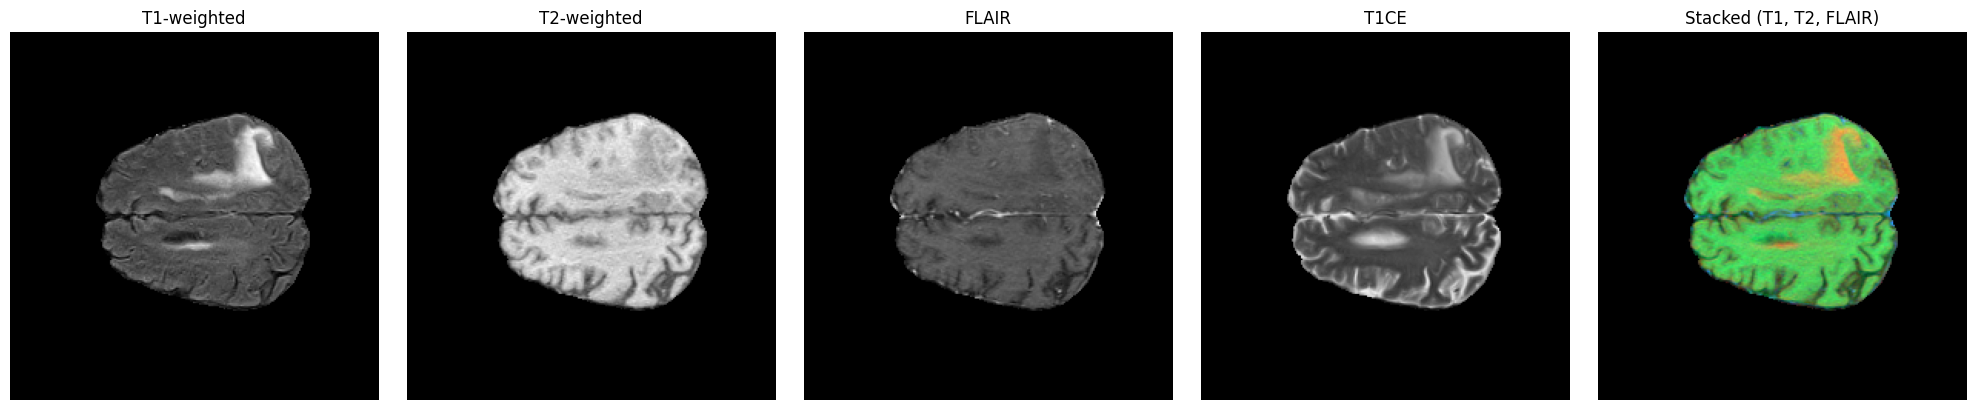

Tensor shape: torch.Size([3, 240, 240])


In [106]:
h5_file_path = "data/BraTS2020_training_data/content/data/volume_100_slice_102.h5"

# Visualize + load as tensor
img_tensor = load_and_visualize_brats_slice(h5_file_path, to_tensor=True)

print("Tensor shape:", img_tensor.shape)  # Should be (3, H, W)


In [107]:
class BraTSSliceDataset(Dataset):
    def __init__(self, data_dir, transform=None, include_mask=True):
        """
        Args:
            data_dir (str): Path to folder with .h5 files
            transform (callable, optional): Optional transforms applied to image/mask
            include_mask (bool): If True, expects 'mask' dataset in each .h5 file
        """
        self.data_dir = data_dir
        self.file_list = sorted([f for f in os.listdir(data_dir) if f.endswith(".h5")])
        self.transform = transform
        self.include_mask = include_mask

    def __len__(self):
        return len(self.file_list)

    def normalize(self, img):
        img = img.astype(np.float32)
        img_min, img_max = np.min(img), np.max(img)
        if img_max - img_min > 0:
            img = (img - img_min) / (img_max - img_min)
        return img

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.file_list[idx])

        with h5py.File(file_path, "r") as f:
            image = f["image"][:]  # (H, W, 4)
            if self.include_mask and "mask" in f.keys():
                mask = f["mask"][:]
                if mask.ndim == 3:  # (H, W, C)
                    mask = np.argmax(mask, axis=-1) 
            else:
                mask = np.zeros(image.shape[:2])

        # Normalize and stack [T1, T2, FLAIR]
        t1 = self.normalize(image[:, :, 0])
        t2 = self.normalize(image[:, :, 1])
        flair = self.normalize(image[:, :, 2])
        stacked = np.stack([t1, t2, flair], axis=0)  # (3, H, W)

        img_tensor = torch.from_numpy(stacked).float()
        mask_tensor = torch.from_numpy(mask).long()
        mask_tensor = TF.resize(mask_tensor.unsqueeze(0), (224, 224), interpolation=TF.InterpolationMode.NEAREST).squeeze(0)

        if self.transform:
            img_tensor = self.transform(img_tensor)
        return img_tensor, mask_tensor


In [119]:
import pandas as pd
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset

class BraTSSliceCSVDataset(Dataset):
    def __init__(self, csv_file, transform=None, include_mask=True):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.include_mask = include_mask

    def __len__(self):
        return len(self.df)

    def normalize(self, img):
        img = img.astype(np.float32)
        img_min, img_max = np.min(img), np.max(img)
        if img_max - img_min > 0:
            img = (img - img_min) / (img_max - img_min)
        return img

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        h5_path = row['slice_path']
        
        with h5py.File(h5_path, "r") as f:
            image = f["image"][:]  # (H, W, 4)
            if self.include_mask and "mask" in f.keys():
                mask = f["mask"][:]
                if mask.ndim == 3:
                    mask = np.argmax(mask, axis=-1)
            else:
                mask = np.zeros(image.shape[:2], dtype=np.uint8)

        # Normalize and stack [T1, T2, FLAIR]
        t1 = self.normalize(image[:, :, 0])
        t2 = self.normalize(image[:, :, 1])
        flair = self.normalize(image[:, :, 2])
        stacked = np.stack([t1, t2, flair], axis=0)

        img_tensor = torch.from_numpy(stacked).float()
        mask_tensor = torch.from_numpy(mask).long()

        # Optional slice-level label for classification
        label = torch.tensor(row["target"], dtype=torch.long)

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, mask_tensor, label


In [120]:
data_dir = "data/BraTS2020_training_data/content/data/"  # adjust path if needed
dataset = BraTSSliceCSVDataset(data_dir=data_dir)

TypeError: __init__() got an unexpected keyword argument 'data_dir'

In [110]:
# Transform
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.ToTensor(),
    ])
    
val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

In [111]:
from torch.utils.data import random_split

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)


In [112]:
# Wrap subsets to include transforms dynamically
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform


In [113]:

print("Number of slices:", len(dataset))

Number of slices: 57195


In [114]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 40036, Val: 11439, Test: 5720


In [115]:
for img, mask in train_loader:
    print(img.shape)
    print(mask.shape)
    break


torch.Size([64, 3, 224, 224])
torch.Size([64, 224, 224])


In [116]:
def dice_metric(preds, targets, smooth=1e-6):
    print(targets.shape)
    print(preds.shape)
    preds = F.softmax(preds, dim=1)
    num_classes = preds.shape[1]
    preds_onehot = torch.argmax(preds, dim=1)
    targets_onehot = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2).float()


    dice_scores = []
    for c in range(num_classes):
        pred_c = (preds_onehot == c).float()
        target_c = (targets_onehot == c).float()
        
        intersection = (pred_c * target_c).sum()
        denominator = pred_c.sum() + target_c.sum()
        dice = (2 * intersection + smooth) / (denominator + smooth)
        dice_scores.append(dice.item())
    
    return sum(dice_scores) / num_classes

In [100]:
from diceLoss import DiceLoss
from swinTransformer import SwinTransformer


from tqdm import tqdm
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
num_epochs = 30
model = SwinTransformer(
    img_size=224, in_chans=3, num_classes=4,  # e.g., 4 tumor classes
    embed_dim=96, depths=(2,2,6,2), num_heads=(3,6,12,24), window_size=7
)
model.to(device)

criterion = DiceLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # ---------- Validation ----------
    model.eval()
    val_dice = 0.0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            dice_metric(outputs, masks)
        val_dice = dice_metric.aggregate().item()
        dice_metric.reset()
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Dice: {val_dice:.4f}")


Epoch 1/30: 100%|██████████| 5005/5005 [13:00<00:00,  6.41it/s]


torch.Size([8, 224, 224])
torch.Size([8, 4])


RuntimeError: The size of tensor a (8) must match the size of tensor b (224) at non-singleton dimension 3

In [117]:
imgs, masks = next(iter(train_loader))
print(imgs.shape)   # should be (B, 3, H, W)
print(masks.shape)  # should be (B, H, W)


torch.Size([64, 3, 224, 224])
torch.Size([64, 224, 224])


In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SwinUNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.backbone = SwinTransformer(
            img_size=224, in_chans=3, num_classes=0,  # no classification head
            embed_dim=96, depths=(2,2,6,2), num_heads=(3,6,12,24),
            window_size=7, include_head=False
        )
        self.up1 = nn.ConvTranspose2d(768, 384, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(384, 192, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(192, 96, kernel_size=2, stride=2)
        self.final = nn.Conv2d(96, num_classes, kernel_size=1)

    def forward(self, x):
        # Get features (B, HW/16, 768)
        feats = self.backbone.forward_features(x)
        B = x.shape[0]
        feats = feats.unsqueeze(-1).unsqueeze(-1)  # (B, 768, 1, 1)
        x = F.relu(self.up1(feats))
        x = F.relu(self.up2(x))
        x = F.relu(self.up3(x))
        x = self.final(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return x

from tqdm import tqdm
import torch

print(f"🚀 Using device: {device}")

model = SwinUNet(num_classes=4).to(device)
criterion = DiceLoss()  # your imported DiceLoss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss/len(train_loader):.4f}")

    # optional validation
    model.eval()
    val_dice = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            val_dice += criterion(outputs, masks).item()
    print(f"Validation Dice Loss: {val_dice/len(val_loader):.4f}")


🚀 Using device: mps


Epoch 1/30: 100%|██████████| 626/626 [12:30<00:00,  1.20s/it]


Epoch 1/30 - Train Loss: 0.7487
Validation Dice Loss: 0.7394


Epoch 2/30: 100%|██████████| 626/626 [12:28<00:00,  1.20s/it]


Epoch 2/30 - Train Loss: 0.6135
Validation Dice Loss: 0.4892


Epoch 3/30: 100%|██████████| 626/626 [12:25<00:00,  1.19s/it]


Epoch 3/30 - Train Loss: 0.4897
Validation Dice Loss: 0.4892


Epoch 4/30: 100%|██████████| 626/626 [12:25<00:00,  1.19s/it]


Epoch 4/30 - Train Loss: 0.4896
Validation Dice Loss: 0.4891


Epoch 5/30: 100%|██████████| 626/626 [12:25<00:00,  1.19s/it]


Epoch 5/30 - Train Loss: 0.4896
Validation Dice Loss: 0.4891


Epoch 6/30: 100%|██████████| 626/626 [12:29<00:00,  1.20s/it]


Epoch 6/30 - Train Loss: 0.4896
Validation Dice Loss: 0.4891


Epoch 7/30: 100%|██████████| 626/626 [12:59<00:00,  1.25s/it]


Epoch 7/30 - Train Loss: 0.4896
Validation Dice Loss: 0.4891


Epoch 8/30: 100%|██████████| 626/626 [12:31<00:00,  1.20s/it]


Epoch 8/30 - Train Loss: 0.4896
Validation Dice Loss: 0.4891


Epoch 9/30: 100%|██████████| 626/626 [12:30<00:00,  1.20s/it]


Epoch 9/30 - Train Loss: 0.4896
Validation Dice Loss: 0.4891


Epoch 10/30: 100%|██████████| 626/626 [12:25<00:00,  1.19s/it]


Epoch 10/30 - Train Loss: 0.4895
Validation Dice Loss: 0.4890


Epoch 11/30: 100%|██████████| 626/626 [12:24<00:00,  1.19s/it]


Epoch 11/30 - Train Loss: 0.4895
Validation Dice Loss: 0.4890


Epoch 12/30: 100%|██████████| 626/626 [12:20<00:00,  1.18s/it]


Epoch 12/30 - Train Loss: 0.4895
Validation Dice Loss: 0.4890


Epoch 13/30: 100%|██████████| 626/626 [13:15<00:00,  1.27s/it]  


Epoch 13/30 - Train Loss: 0.4895
Validation Dice Loss: 0.4889


Epoch 14/30: 100%|██████████| 626/626 [12:28<00:00,  1.20s/it]


Epoch 14/30 - Train Loss: 0.4895
Validation Dice Loss: 0.4889


Epoch 15/30: 100%|██████████| 626/626 [12:27<00:00,  1.19s/it]


Epoch 15/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


Epoch 16/30: 100%|██████████| 626/626 [12:24<00:00,  1.19s/it]


Epoch 16/30 - Train Loss: 0.4895
Validation Dice Loss: 0.4889


Epoch 17/30: 100%|██████████| 626/626 [12:32<00:00,  1.20s/it]


Epoch 17/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


Epoch 18/30: 100%|██████████| 626/626 [12:25<00:00,  1.19s/it]


Epoch 18/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


Epoch 19/30: 100%|██████████| 626/626 [12:27<00:00,  1.19s/it]


Epoch 19/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


Epoch 20/30: 100%|██████████| 626/626 [12:18<00:00,  1.18s/it]


Epoch 20/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


Epoch 21/30: 100%|██████████| 626/626 [12:25<00:00,  1.19s/it]


Epoch 21/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


Epoch 22/30: 100%|██████████| 626/626 [2:28:07<00:00, 14.20s/it]    


Epoch 22/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


Epoch 23/30: 100%|██████████| 626/626 [12:12<00:00,  1.17s/it]


Epoch 23/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


Epoch 24/30: 100%|██████████| 626/626 [12:14<00:00,  1.17s/it]


Epoch 24/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


Epoch 25/30: 100%|██████████| 626/626 [12:12<00:00,  1.17s/it]


Epoch 25/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


Epoch 26/30: 100%|██████████| 626/626 [27:59<00:00,  2.68s/it]   


Epoch 26/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


Epoch 27/30: 100%|██████████| 626/626 [2:38:18<00:00, 15.17s/it]    


Epoch 27/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


Epoch 28/30: 100%|██████████| 626/626 [34:11<00:00,  3.28s/it]


Epoch 28/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


Epoch 29/30: 100%|██████████| 626/626 [39:17<00:00,  3.77s/it]    


Epoch 29/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


Epoch 30/30: 100%|██████████| 626/626 [12:27<00:00,  1.19s/it]


Epoch 30/30 - Train Loss: 0.4894
Validation Dice Loss: 0.4889


In [123]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
with torch.no_grad():
    # Take one batch from validation loader
    imgs, masks = next(iter(val_loader))
    imgs, masks = imgs.to(device), masks.to(device)
    
    # Forward pass
    outputs = model(imgs)  # shape: (B, num_classes, H, W)
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)  # shape: (B, H, W)


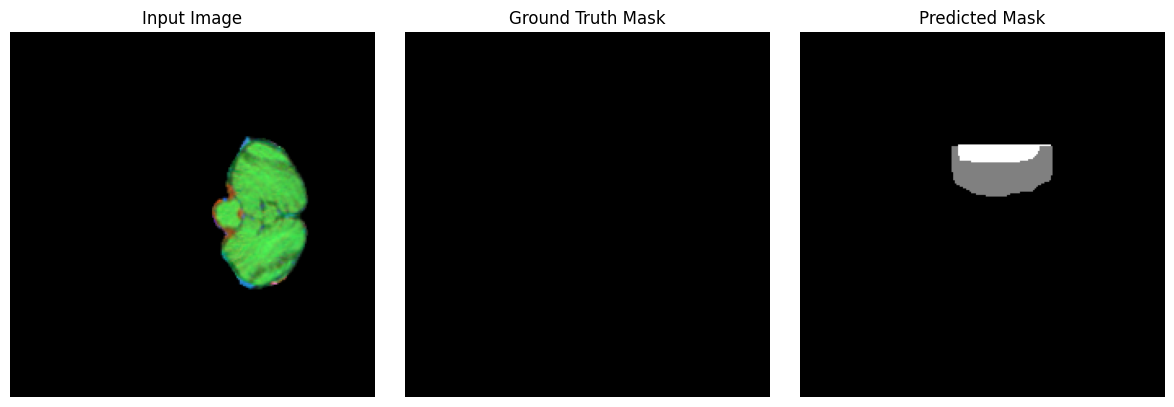

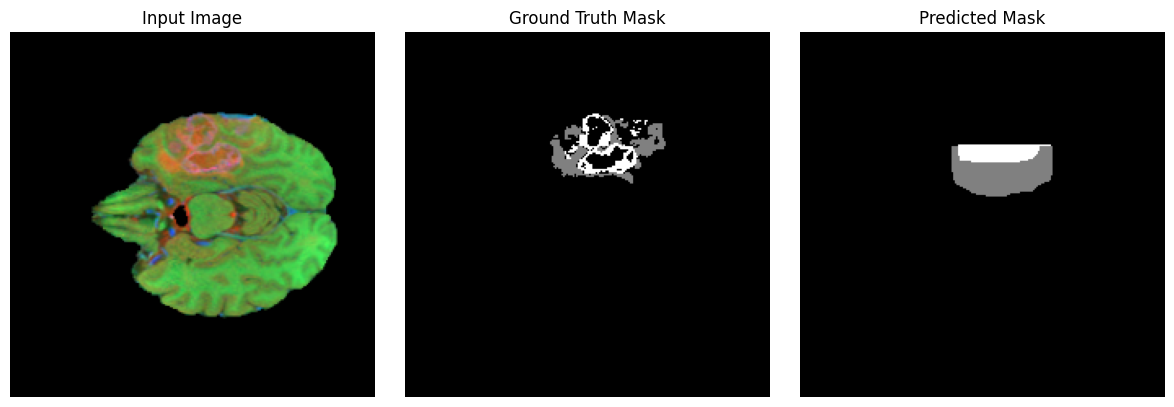

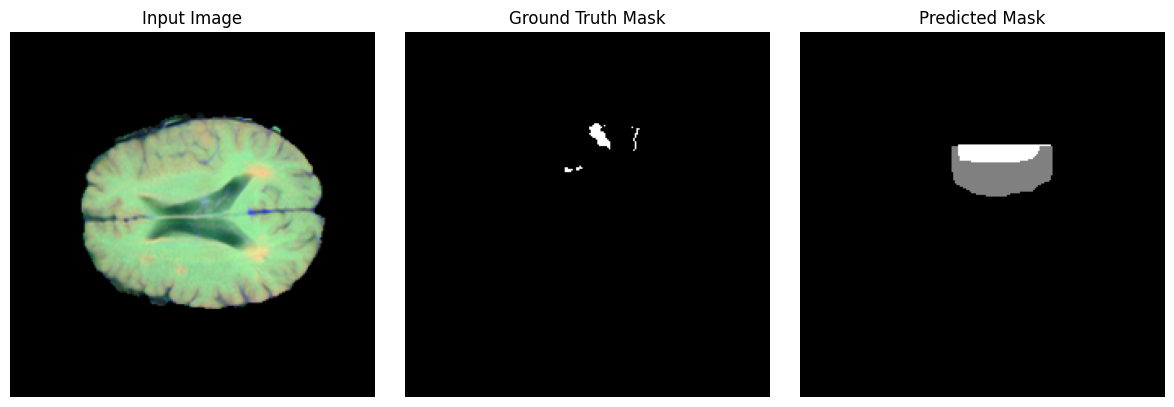

In [124]:
def show_prediction(img, true_mask, pred_mask):
    # Move tensors to CPU and detach
    img = img.permute(1, 2, 0).cpu().numpy()
    true_mask = true_mask.cpu().numpy()
    pred_mask = pred_mask.cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    axes[1].imshow(true_mask, cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(pred_mask, cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Example: visualize first 3 predictions
for i in range(3):
    show_prediction(imgs[i], masks[i], preds[i])


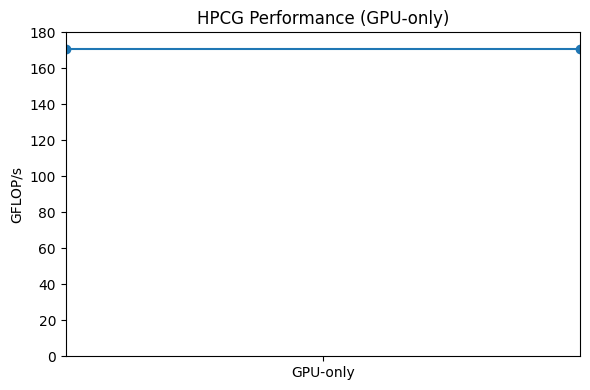

In [4]:
import matplotlib.pyplot as plt

# Single GPU HPCG result
gflops_gpu = 170.501

# Fake x-axis just to draw a line
x = [0, 1]
y = [gflops_gpu, gflops_gpu]

plt.figure(figsize=(6,4))
plt.plot(x, y, marker="o")

plt.xticks([0.5], ["GPU-only"])
plt.xlim(0, 1)

plt.ylim(0, 180)  # Y-axis from 5 to 170
plt.ylabel("GFLOP/s")
plt.title("HPCG Performance (GPU-only)")
plt.tight_layout()
plt.show()
